<h1>Recreating Results of Syracuse Paper</h1>

In [1]:
import sys  
sys.path.insert(1, '../src')

In [2]:
import os
import numpy as np
import pandas as pd

from utils import * 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, auc, roc_auc_score, roc_curve, precision_recall_curve, precision_score, recall_score, accuracy_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, average_precision_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np 
import os 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.datasets import load_iris, make_classification
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from xgboost import XGBRegressor, XGBClassifier

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

In [3]:
pd.options.mode.chained_assignment = None

In [68]:
dfX = pd.read_csv("../data/transformed/watermain_breaks_train.csv")
valX = pd.read_csv("../data/transformed/watermain_breaks_validation.csv")
testX = pd.read_csv("../data/transformed/watermain_breaks_test.csv")
predsX = pd.read_csv("../data/transformed/watermain_breaks_dataset.csv")

In [147]:
len(valX.most_recent_break.unique()) + len(testX.most_recent_break.unique()) + len(dfX.most_recent_break.unique())

673

In [6]:
len(predsX.most_recent_break.unique())

671

<h2>Prepare Data</h2>

2015-2018 is our target period

Outcome: if the pipe will breaks in the next 3 years

In [81]:
#looking from 2015 trying to predict next 3 years
CUTOFF = pd.to_datetime('01-01-2016')

TEST_VAL_CUTOFF = pd.to_datetime('01-01-2019')
PREDS_CUTOFF = pd.to_datetime('08-01-2019')
PREDS_CUTOFF2 = pd.to_datetime('01-01-2010')
DUMMY_CUTOFF = pd.to_datetime('01-01-2024')

In [82]:
preds_df = process_date_cols(predsX, PREDS_CUTOFF2)
cols = ['PressureSy', 'STATUS', 'MATERIAL', 'SUBTYPE']
preds_df = svm_data_transform_pipeline(preds_df, PREDS_CUTOFF2, cols)
pred_test_df =  process_date_cols(predsX, DUMMY_CUTOFF)
cols = ['PressureSy', 'STATUS', 'MATERIAL', 'SUBTYPE']
pred_test_df = svm_data_transform_pipeline(pred_test_df, DUMMY_CUTOFF, cols)

In [83]:
all_cols_pred = list(pred_test_df.columns) 
all_cols_pred.extend(list(preds_df.columns))


for col in all_cols_pred: 
    if col not in list(pred_test_df.columns):
        pred_test_df[col] = 0
    if col not in list(preds_df.columns):
        preds_df[col] = 0


In [11]:
preds_df.installation_year.unique()

array([2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994,
       1993, 1992, 1991, 1990, 1989, 1988, 1987, 1986, 1985, 1984, 1983,
       1982, 1981, 1980, 1979, 1978, 1977, 1976, 1975, 1974, 1973, 1972,
       1971, 1970, 1969, 1968, 1967, 1966, 1965, 1964, 1963, 1962, 1961,
       1960, 1959, 1958, 1956, 1950, 1940, 1939, 1930, 1925, 1924, 1923,
       1922, 1920, 1919, 1917, 1911, 1910, 1909, 1908, 1907, 1906, 1905,
       1904, 1903, 1902, 1901, 1900, 1899, 1897, 1896, 1895, 1892, 1891,
       1890, 1889, 1887, 1886, 1880])

In [69]:
pred_test_df


,LENGTH,DIAMETER,will_break,installation_year,n_previous_breaks,delta_installation_to_first_break,delta_installation_to_most_recent_break,GRA,NEDPRZ,NEH,...,HDPE,PVC,RC,ST,STL,UNK,Hydrant Lead,Other,Raw Water,Transmission Main
0,7.0,6.0,0,2023,0,81,81,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,9.0,6.0,0,2023,0,88,88,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,20.0,6.0,0,2023,0,139,139,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,9.0,6.0,0,2023,0,140,140,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,13.0,6.0,0,2023,0,167,167,1,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27474,71.0,6.0,0,1950,1,23042,23042,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27475,19.0,10.0,0,2009,1,4077,4077,1,0,0,...,0,0,0,0,0,0,0,0,0,0
27476,43.0,6.0,0,1962,1,20709,20709,0,0,1,...,0,0,0,0,0,0,0,0,0,0
27477,0.0,6.0,0,1960,1,22604,22604,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
preds_df

,LENGTH,DIAMETER,will_break,installation_year,n_previous_breaks,delta_installation_to_first_break,delta_installation_to_most_recent_break,GRA,NEDPRZ,NEH,...,HDPE,PVC,RC,ST,STL,UNK,Hydrant Lead,Other,Raw Water,Transmission Main
763,38.0,8.0,0,2019,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
764,24.0,6.0,0,2019,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
765,45.0,8.0,0,2019,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
766,21.0,6.0,0,2019,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
768,3.0,8.0,0,2019,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27474,71.0,6.0,0,1950,1,23042,23042,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27475,19.0,10.0,1,2009,0,3523,3523,1,0,0,...,0,0,0,0,0,0,0,0,0,0
27476,43.0,6.0,0,1962,1,20709,20709,0,0,1,...,0,0,0,0,0,0,0,0,0,0
27477,0.0,6.0,1,1960,0,21762,21762,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
preds_df[preds_df['will_break'] == 1].shape

(669, 32)

In [13]:
df = process_date_cols(dfX, CUTOFF)

In [14]:
cols = ['PressureSy', 'STATUS', 'MATERIAL', 'SUBTYPE']
df = svm_data_transform_pipeline(df, CUTOFF, cols)

In [15]:
val = process_date_cols(valX, TEST_VAL_CUTOFF)
val = svm_data_transform_pipeline(val, TEST_VAL_CUTOFF, cols)


test = process_date_cols(testX, TEST_VAL_CUTOFF)
test = svm_data_transform_pipeline(test, TEST_VAL_CUTOFF, cols)

In [10]:
cols = ['PressureSy', 'STATUS', 'MATERIAL', 'SUBTYPE']
val_2023 = process_date_cols(valX, PREDS_CUTOFF)
val_2023 = svm_data_transform_pipeline(val_2023, PREDS_CUTOFF, cols)


test_2023 = process_date_cols(testX, PREDS_CUTOFF)
test_2023 = svm_data_transform_pipeline(test_2023, PREDS_CUTOFF, cols)

df = process_date_cols(dfX, CUTOFF)
cols = ['PressureSy', 'STATUS', 'MATERIAL', 'SUBTYPE']
df = svm_data_transform_pipeline(df, CUTOFF, cols)


all_cols = list(test_2023.columns) 
all_cols.extend(list(df.columns))
all_cols.extend(list(val_2023.columns))


for col in all_cols: 
    if col not in list(test_2023.columns):
        test_2023[col] = 0
    if col not in list(val_2023.columns):
        val_2023[col] = 0
    if col not in list(df.columns):
        df[col] = 0

X_test_2023 = test_2023.drop(columns = ['will_break'])
y_test_2023 = test_2023['will_break']

X_val_2023 = val_2023.drop(columns = ['will_break'])
y_val_2023 = val_2023['will_break']

In [11]:
val_2023[val_2023['will_break'] == 1]

,LENGTH,DIAMETER,will_break,installation_year,n_previous_breaks,delta_installation_to_first_break,delta_installation_to_most_recent_break,GRA,NEH,NEHEPRZ,...,Other,Transmission Main,C909,GAL,UNK,NEDPRZ,OTH,ST,STL,Raw Water
1418,21.0,6.0,1,1950,0,25933,25933,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1421,7.0,6.0,1,1910,0,40543,40543,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1445,311.0,6.0,1,1889,0,48212,48212,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1446,593.0,6.0,1,1905,0,42369,42369,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1456,499.0,8.0,1,1960,0,22281,22281,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1457,384.0,6.0,1,1960,0,22250,22250,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1458,435.0,6.0,1,1950,0,25933,25933,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
len(X_test_2023.columns)

32

In [37]:
X_test_2023.installation_year.unique()

array([2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008,
       2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997,
       1996, 1995, 1994, 1993, 1992, 1991, 1990, 1989, 1988, 1987, 1986,
       1985, 1984, 1983, 1982, 1981, 1980, 1979, 1978, 1977, 1976, 1975,
       1974, 1973, 1972, 1971, 1970, 1969, 1968, 1967, 1966, 1965, 1964,
       1963, 1962, 1961, 1960, 1959, 1958, 1950, 1940, 1930, 1920, 1917,
       1911, 1910, 1909, 1907, 1906, 1905, 1904, 1902, 1901, 1900, 1899,
       1896, 1895, 1890, 1889, 1886, 1880, 1892])

In [38]:
X_val_2023.installation_year.unique()

array([2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008,
       2007, 2006, 2005, 2004, 2003, 2002, 2001, 2000, 1999, 1998, 1997,
       1996, 1995, 1994, 1993, 1992, 1991, 1990, 1989, 1988, 1987, 1986,
       1985, 1984, 1983, 1982, 1981, 1980, 1979, 1978, 1977, 1976, 1975,
       1974, 1973, 1972, 1971, 1970, 1969, 1968, 1967, 1966, 1965, 1964,
       1963, 1962, 1961, 1960, 1959, 1958, 1950, 1940, 1930, 1924, 1920,
       1911, 1910, 1909, 1907, 1906, 1905, 1904, 1903, 1902, 1901, 1900,
       1899, 1897, 1896, 1895, 1892, 1891, 1890, 1887, 1886, 1880, 1889])

<h3>Handling some differences in dummy variables</h3>

In [16]:
all_cols = list(test.columns) 
all_cols.extend(list(df.columns))
all_cols.extend(list(val.columns))

for col in all_cols: 
    if col not in list(test.columns):
        test[col] = 0
    if col not in list(val.columns):
        val[col] = 0
    if col not in list(df.columns):
        df[col] = 0

<h2>Split</h2>

In [17]:
X_train = df.drop(columns = ['will_break'])
y_train = df['will_break']

X_test = test.drop(columns = ['will_break'])
y_test = test['will_break']

X_val = val.drop(columns = ['will_break'])
y_val = val['will_break']

In [18]:
len(X_test.columns)

32

In [13]:
X_test.installation_year.value_counts().index.sort_values()

Index([1880, 1886, 1889, 1890, 1892, 1895, 1896, 1899, 1900, 1901, 1902, 1904,
       1905, 1906, 1907, 1909, 1910, 1911, 1917, 1920, 1930, 1940, 1950, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
      dtype='int64', name='installation_year')

In [14]:
np.where(y_train == 1)

(array([], dtype=int64),)

In [102]:
pd.to_datetime(X_test['installation_year'], unit='D').dt.year
# X_test['installation_year'] = X_test['installation_year'].dt.year

716     1975
717     1975
718     1975
719     1975
720     1975
        ... 
3851    1975
3852    1975
3853    1975
3854    1975
3855    1975
Name: installation_year, Length: 3073, dtype: int32

In [41]:
sorted(X_train.installation_year.unique())

[1880,
 1886,
 1889,
 1890,
 1891,
 1895,
 1897,
 1900,
 1901,
 1902,
 1903,
 1904,
 1905,
 1906,
 1907,
 1909,
 1910,
 1911,
 1920,
 1930,
 1939,
 1940,
 1950,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015]

<h2>Scaling</h2>

In [113]:
numeric_cols = list(X_train.columns)
numeric_cols.remove('installation_year')

In [288]:
len(list(X_train.columns))

32

In [114]:
numeric_cols = list(X_train.columns)
numeric_cols.remove('installation_year')
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
    ]
)

In [121]:
# concat xval and x test
X_val_test = pd.concat([X_val, X_test], axis = 0)
y_val_test = pd.concat([y_val, y_test], axis = 0)
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", SVC(C=15, class_weight='balanced',  kernel='rbf'))]
)
# probability =True
clf.fit(X_train, y_train)
preds = clf.predict(X_val_test)
print(classification_report(y_val_test, preds))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90      3562
           1       0.03      0.64      0.06        36

    accuracy                           0.82      3598
   macro avg       0.51      0.73      0.48      3598
weighted avg       0.99      0.82      0.89      3598



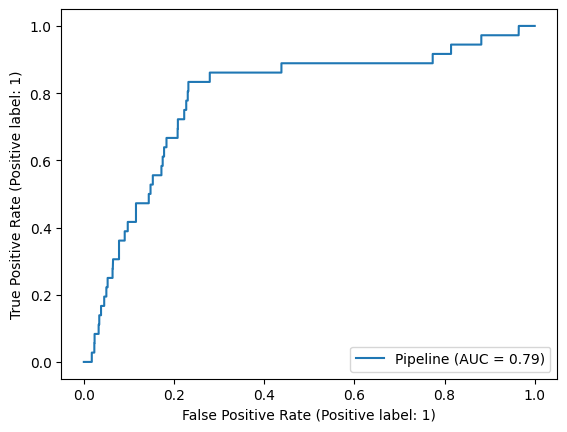

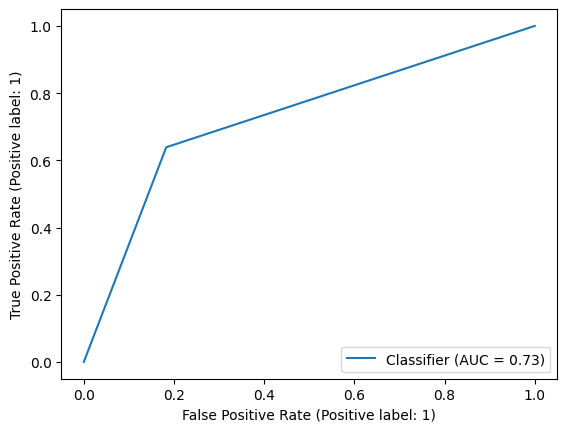

In [123]:
RocCurveDisplay.from_estimator(clf, X_val_test, y_val_test)
RocCurveDisplay.from_predictions(y_val_test, preds)

In [71]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled = scaler.transform(X_test[numeric_cols])
X_val_scaled = scaler.transform(X_val[numeric_cols])

X_train = np.concatenate([X_train_scaled, np.array(X_train['installation_year'].values).reshape(-1, 1)], axis = 1)
X_test = np.concatenate([X_test_scaled, np.array(X_test['installation_year'].values).reshape(-1, 1)], axis = 1)
X_val = np.concatenate([X_val_scaled, np.array(X_val['installation_year'].values).reshape(-1, 1)], axis = 1)

In [19]:
models = [
  

    ("Logistic Regression Classification", LogisticRegression(), {'model__C': [0.05, 0.005, 0.1, 0.25, 0.5, 1, 2, 5], 'model__max_iter': [1000], 'model__intercept_scaling': [1, 2, 3, 4, 5], 'model__class_weight': ['balanced', None], 'model__random_state': [13]}),
    # ("SVC - C5", SVC(C = 5, class_weight='balanced'), {'model__C': [5, 10, 15], 'model__gamma': ['scale', 'auto']}),
    # ("SVC2 - C 20", SVC(C = 20, class_weight='balanced'), {'model__C': [5, 10, 15], 'model__gamma': ['scale', 'auto']}),
    # ("SVC3 - C 15", SVC(C = 15, class_weight='balanced'), {'model__C': [5, 10, 15], 'model__gamma': ['scale', 'auto']}),
    # ("SVC4 - C1", SVC(C = 1, class_weight='balanced'), {'model__C': [5, 10, 15], 'model__gamma': ['scale', 'auto']}),
    # ("SVC5 - C10", SVC(C = 10, class_weight='balanced'), {'model__C': [5, 10, 15], 'model__gamma': ['scale', 'auto']}),
    ("SVC", SVC(), {'model__C': [5, 7, 10, 12, 15, 18], 'model__gamma': ['scale', 'auto', 0.05], 'model__class_weight': ['balanced'], 'model__random_state': [13], 'model__probability': [True]}),
    # ("Decision Tree Regression", DecisionTreeClassifier(), {'model__max_depth':[None,2, 5]}),
    ("Random Forest Classification", RandomForestClassifier(), {'model__n_estimators': [75, 90, 100, 110, 125, 150,200, 225, 250], 'model__max_depth':[ 3, 4, 5, 6], 'model__min_samples_split': [3], 'model__min_weight_fraction_leaf':[0, 0.001],'model__max_features': ['sqrt', 'log2',16, 17], 'model__random_state': [13]}), # 'model__class_weight': ['balanced', None]}),
    # ("Random Forest Classification2", RandomForestClassifier(min_samples_split = 3,  n_estimators=75), {'model__n_estimators': [100,150,200]}), 
    #'model__max_features': ['sqrt', 'log2', 15, 16, 17]

    #'model__class_weight': ['balanced']

    # ("Gradient Boosting Classification", GradientBoostingClassifier(n_estimators=440, max_depth=5, learning_rate=0.012, random_state=0, max_features='sqrt'), {'model__n_estimators': [100,150,200]}),
    # ("Gradient Boosting Classification", GradientBoostingClassifier(), {'model__n_estimators': [100, 150,200, 300, 450, 500], 'model__max_depth': [3, 5, 4, 6,7], 'model__learning_rate': [0.01, 0.025, .05, 0.75, 0.1], 'model__max_features': ['sqrt', 'log2'], 'model__random_state': [13]}),
    # ("Gradient Boosting Classification2", GradientBoostingClassifier( n_estimators=100, max_depth=7, learning_rate=0.2, random_state=0, max_features='sqrt'), {'model__n_estimators': [100,150,200]}),
    # ("Gradient Boosting Classification3", GradientBoostingClassifier( n_estimators=375, max_depth=3, learning_rate=0.02, random_state=0, max_features=2), {'model__n_estimators': [100,150,200]}),
    # ('xgb', XGBClassifier(), {'model__n_estimators': [100,150,200]}),

    # ("K-Nearest Neighbors Classification", KNeighborsClassifier(), {'model__n_neighbors': [3,5]}),
    #("Neural Network Classification", MLPClassifier(max_iter=1000)),  # Specify appropriate hyperparameters

    
]

In [110]:
# concat xval and x test
X_val_test = np.concatenate([X_val, X_test], axis = 0)
y_val_test = np.concatenate([y_val, y_test], axis = 0)

class 0: (19405, 33)
class 1: (157, 33)
total class of 1 and0: will_break
0    1413
1     157
Name: count, dtype: int64


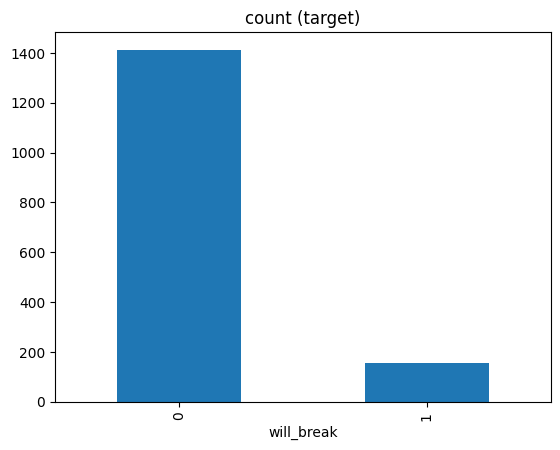

In [20]:
# class count
class_count_0, class_count_1 = df['will_break'].value_counts()

# Separate class
class_0 = df[df['will_break'] == 0]
class_1 = df[df['will_break'] == 1]# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)
class_0_under = class_0.sample(class_count_1*9, random_state=14)

test_under = pd.concat([class_0_under, class_1], axis=0)
print("total class of 1 and0:",test_under['will_break'].value_counts()) # plot the count after under-sampling
test_under['will_break'].value_counts().plot(kind='bar', title='count (target)')

y_train = test_under['will_break']
X_train = test_under.drop(columns = ['will_break'])

X_val_test = pd.concat([X_val, X_test], axis = 0)
y_val_test = pd.concat([y_val, y_test], axis = 0)

In [89]:
len(np.where(y_val_test == 1)[0])

36

total class of 1 and0: will_break
0    1256
1     157
Name: count, dtype: int64


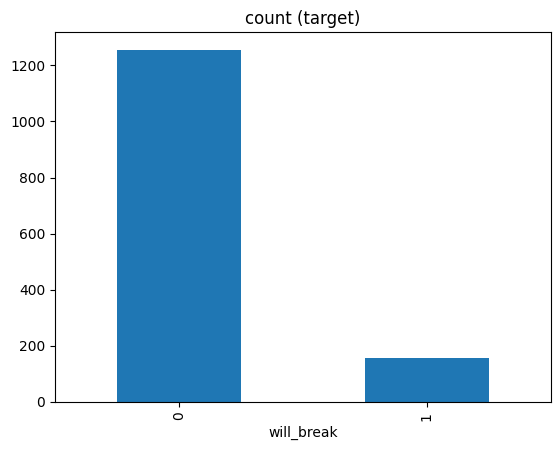

In [59]:
class_0_under = class_0.sample(class_count_1*8)

test_under = pd.concat([class_0_under, class_1], axis=0)
print("total class of 1 and0:",test_under['will_break'].value_counts()) # plot the count after under-sampling
test_under['will_break'].value_counts().plot(kind='bar', title='count (target)')

y_train = test_under['will_break']
test_under = test_under.drop(columns = ['will_break'])
numeric_cols = list(test_under.columns)
numeric_cols.remove('installation_year')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(test_under[numeric_cols])
X_test_scaled = scaler.transform(X_test[numeric_cols])
X_val_scaled = scaler.transform(X_val[numeric_cols])

X_train = np.concatenate([X_train_scaled, np.array(test_under['installation_year'].values).reshape(-1, 1)], axis = 1)
X_test = np.concatenate([X_test_scaled, np.array(X_test['installation_year'].values).reshape(-1, 1)], axis = 1)
X_val = np.concatenate([X_val_scaled, np.array(X_val['installation_year'].values).reshape(-1, 1)], axis = 1)
X_val_test = np.concatenate([X_val, X_test], axis = 0)
y_val_test = np.concatenate([y_val, y_test], axis = 0)

In [52]:
from imblearn.over_sampling import SMOTE
from collections import Counter
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(X_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 1570, 1: 157})
Resample dataset shape Counter({0: 1570, 1: 1570})


32

In [89]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression, SelectKBest, chi2, f_classif
numeric_cols = list(X_train.columns)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_cols])

# X_train_encoded = StandardScaler().fit_transform(X_train)
selector = SelectKBest(f_classif, k=20) 
X_selected = selector.fit_transform(X_train_scaled, y_train)
selected_features = X_train.columns[selector.get_support()]
print("Selected Features:", selected_features)

selector_mi = SelectKBest(mutual_info_classif, k=20) 
X_selected_mi = selector_mi.fit_transform(X_train_scaled, y_train)

# Display the selected features using mutual information
selected_features_mi = X_train.columns[selector_mi.get_support()]
print("Selected Features (Mutual Information):", selected_features_mi)

Selected Features: Index(['LENGTH', 'DIAMETER', 'installation_year', 'n_previous_breaks',
       'delta_installation_to_first_break',
       'delta_installation_to_most_recent_break', 'GRA', 'NEH', 'NEHEPRZ',
       'NEHWPRZ', 'SCIO', 'SHE', 'WNPRZ', 'CI', 'DI', 'GAL', 'HDPE', 'RC',
       'Hydrant Lead', 'Transmission Main'],
      dtype='object')
Selected Features (Mutual Information): Index(['LENGTH', 'DIAMETER', 'installation_year', 'n_previous_breaks',
       'delta_installation_to_first_break',
       'delta_installation_to_most_recent_break', 'GRA', 'NEDPRZ', 'NEHEPRZ',
       'OTH', 'SHE', 'IS', 'CI', 'CU', 'DI', 'GAL', 'PVC', 'ST', 'STL',
       'Hydrant Lead'],
      dtype='object')


/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 7 11 24 25 26 28 29 31] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


(3598,)

Logistic Regression Classification
Fitting 2 folds for each of 80 candidates, totalling 160 fits
best params {'model__C': 2, 'model__class_weight': 'balanced', 'model__intercept_scaling': 1, 'model__max_iter': 1000, 'model__random_state': 13}
              precision    recall  f1-score   support

           0       1.00      0.79      0.88      3562
           1       0.04      0.78      0.07        36

    accuracy                           0.79      3598
   macro avg       0.52      0.78      0.47      3598
weighted avg       0.99      0.79      0.87      3598

auc 0.856202040052405
f1 0.0679611650485437
SVC
Fitting 2 folds for each of 18 candidates, totalling 36 fits
best params {'model__C': 12, 'model__class_weight': 'balanced', 'model__gamma': 'auto', 'model__probability': True, 'model__random_state': 13}
              precision    recall  f1-score   support

           0       1.00      0.80      0.89      3562
           1       0.04      0.83      0.08        36

    accuracy  

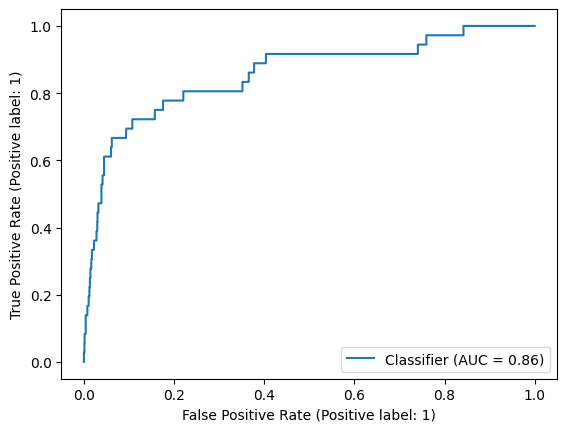

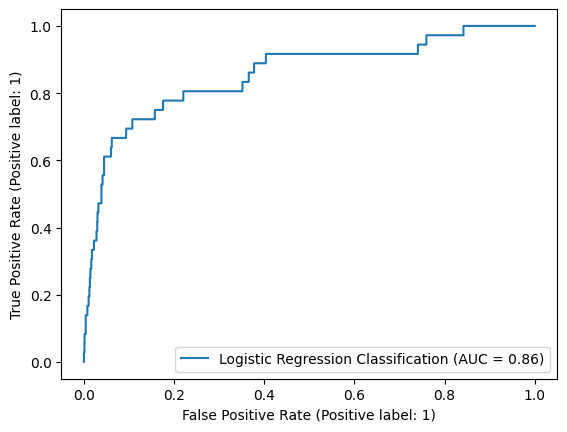

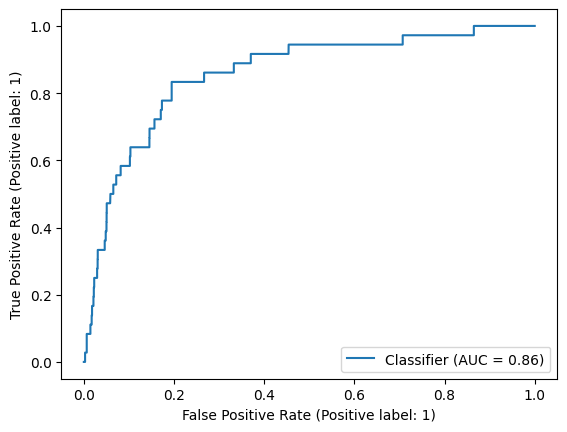

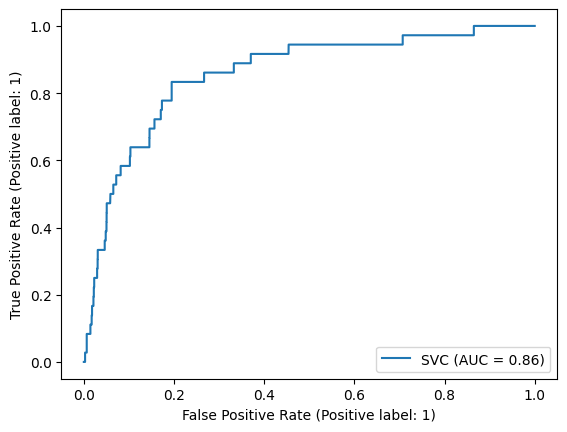

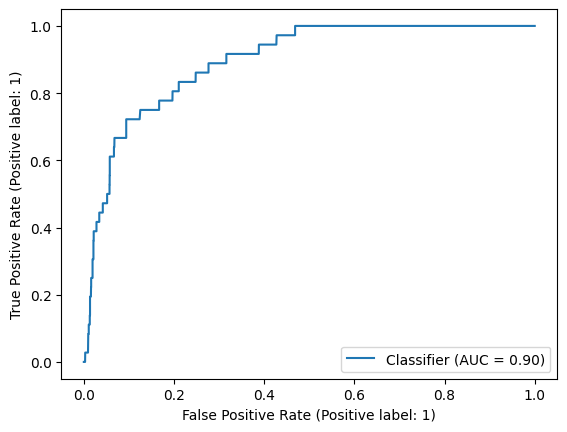

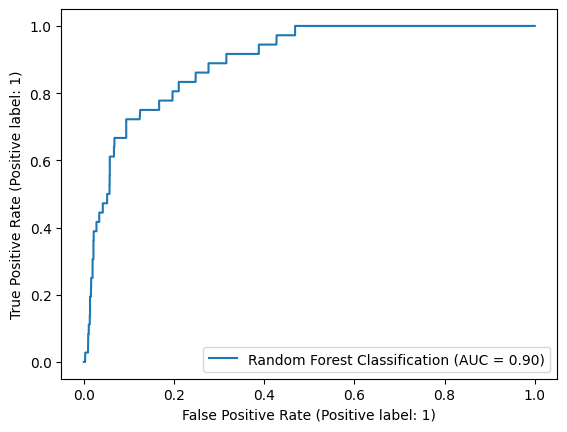

In [92]:
new_model_lists = []
y_probs_list = []
for model in models:
  
    name = model[0]
    params =model[2]
    print(model[0])
    model = model[1]
    numeric_cols = list(df.columns)
    # numeric_cols.remove('installation_year')
    numeric_cols.remove('will_break')
    # potential_drop = ['OTH','WNPRZ','HDPE','RC','Other','NEHEPRZ','NEHWPRZ', 'NEDPRZ', "PVC", "ST", 'STL']
    # for col in potential_drop:
    #     if col in numeric_cols:
    #         numeric_cols.remove(col)
    # numeric_cols.remove('installation_year')
    # numeric_cols.
 
    # numeric_transformer = Pipeline(
    #     steps=[("scaler", StandardScaler())]
    # )


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_cols),
            # ("year", 'passthrough', ['installation_year'])
        ]
    )
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ('model', model)])
    #model.fit(trainX_prepared, trainY)
    grids =  GridSearchCV(pipe, param_grid=params, scoring=['f1', 'roc_auc'], cv=2, refit='f1', verbose=1, n_jobs=-1)
    # cv = [(slice(None), slice(None))]
    grids.fit(X_train, y_train)
    # grids.fit(x_smote, y_smote)
    #  scoring=['f1', 'roc_auc']
    # , 'roc_auc'
    #print('train result', result['test_score'])
    print('best params', grids.best_params_)
    # print('mean_score:', -np.mean(result['test_score']))
    y_preds = grids.best_estimator_.predict(X_val_test)
    new_model_lists.append((name, grids.best_estimator_))
    y_probabs = grids.best_estimator_.predict_proba(X_val_test)
    print(classification_report(y_val_test, y_preds))
    print('auc', roc_auc_score(y_val_test, y_probabs[:,1]))
    print('f1', f1_score(y_val_test, y_preds))
    
    y_probs_list.append(grids.best_estimator_.predict_proba(X_val_test))

    RocCurveDisplay.from_predictions(y_val_test, y_probabs[:,1])
    RocCurveDisplay.from_estimator(grids.best_estimator_, X_val_test, y_val_test, name=name)

In [186]:
len(y_val_test) * 0.03

107.94

In [22]:
zip_preds_rf = list(zip(y_probs_list[2], y_val_test, y_val_test.index))
sortyyy=sorted(zip_preds_rf, key = lambda x: x[0][1], reverse = True)
actual = [x[1] for x in sortyyy[:110]]
preddy = [1 if x[0][1] > 0.5 else 0 for x in sortyyy[:110]]
# for val in sortyyy[:100]:
#     print(val[2])
# preddy = [1 for x in sortyyy[:100] if x[0][1] > 0.5] else 0
average_precision_score(actual, preddy, average='weighted')
# preddy
# y_probs_list[2]

0.14472493798336494

In [41]:

from random import sample 
actual2 = sample([x for x in sortyyy],110)
actual3 = [x[1] for x in actual2]
preddy2 = [1 if x[0][1] > 0.5 else 0 for x in actual2]
average_precision_score(actual3, preddy2, average='weighted')


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


-0.0

In [32]:
X_val_test.head()

,LENGTH,DIAMETER,installation_year,n_previous_breaks,delta_installation_to_first_break,delta_installation_to_most_recent_break,GRA,NEH,NEHEPRZ,NEHWPRZ,...,Other,Transmission Main,C909,GAL,UNK,NEDPRZ,OTH,ST,STL,Raw Water
0,4.0,8.0,2018,0,31,31,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,425.0,12.0,2018,0,92,92,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10.0,12.0,2018,0,92,92,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,8.0,2018,0,92,92,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,29.0,12.0,2018,0,92,92,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [214]:
idx_lx = [x[2] for x in sortyyy[:15]]
idx_lx
import pandas as pd
pd.set_option('display.max_columns', None)
X_val_test.loc[X_val_test.index.isin(idx_lx)][:15]

,LENGTH,DIAMETER,installation_year,n_previous_breaks,delta_installation_to_first_break,delta_installation_to_most_recent_break,GRA,NEH,NEHEPRZ,NEHWPRZ,SCIO,SHE,WH,WNPRZ,IS,CI,CU,DI,HDPE,PVC,RC,Hydrant Lead,Other,Transmission Main,C909,GAL,UNK,NEDPRZ,OTH,ST,STL,Raw Water
1136,300.0,6.0,1950,0,25202,25202,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1224,541.0,8.0,1940,0,28855,28855,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1441,538.0,8.0,1963,1,20166,20166,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1136,32.0,16.0,1973,0,16555,16555,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1224,4.0,4.0,1971,0,17259,17259,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1441,205.0,8.0,1966,0,19139,19139,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1611,348.0,6.0,1960,0,21550,21550,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1657,293.0,8.0,1960,0,21550,21550,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1734,330.0,6.0,1959,0,21915,21915,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1824,299.0,6.0,1950,0,25202,25202,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Logistic Regression Classification
auc 0.6451977665481315


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3562
           1       0.17      0.31      0.22        36

    accuracy                           0.98      3598
   macro avg       0.58      0.65      0.60      3598
weighted avg       0.98      0.98      0.98      3598

f1 0.21782178217821782
SVC - C5
auc 0.7818953147420301
              precision    recall  f1-score   support

           0       1.00      0.67      0.81      3562
           1       0.03      0.89      0.05        36

    accuracy                           0.68      3598
   macro avg       0.51      0.78      0.43      3598
weighted avg       0.99      0.68      0.80      3598

f1 0.05220228384991844
SVC2 - C 20
auc 0.789888639341194
              precision    recall  f1-score   support

           0       1.00      0.66      0.80      3562
           1       0.03      0.92      0.05        36

    accuracy                           0.67      3598
   macro avg    

/opt/homebrew/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


auc 0.649681826689126
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3562
           1       0.09      0.33      0.14        36

    accuracy                           0.96      3598
   macro avg       0.54      0.65      0.56      3598
weighted avg       0.98      0.96      0.97      3598

f1 0.14201183431952663


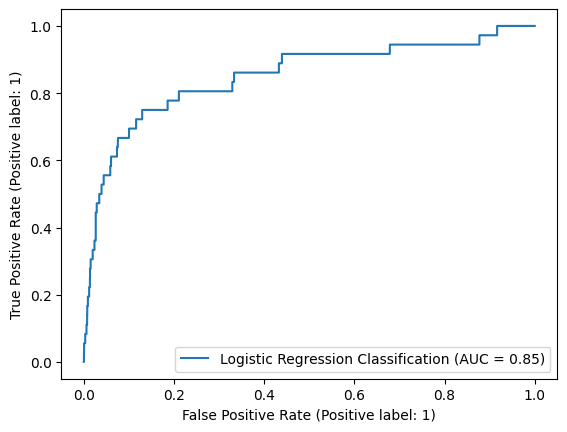

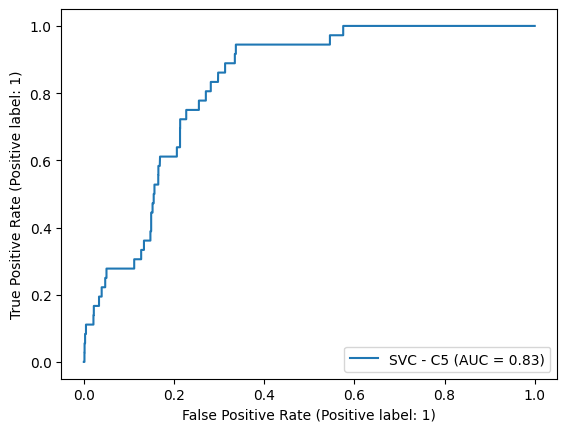

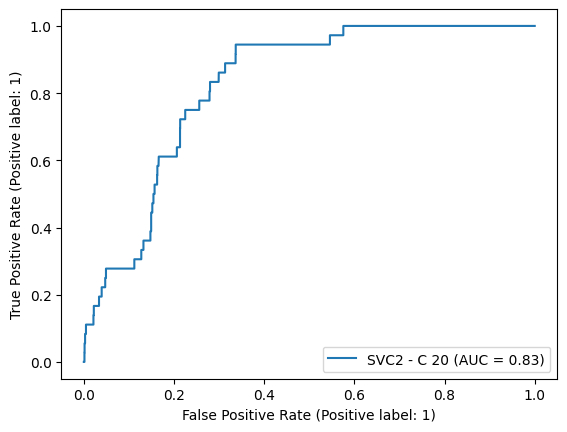

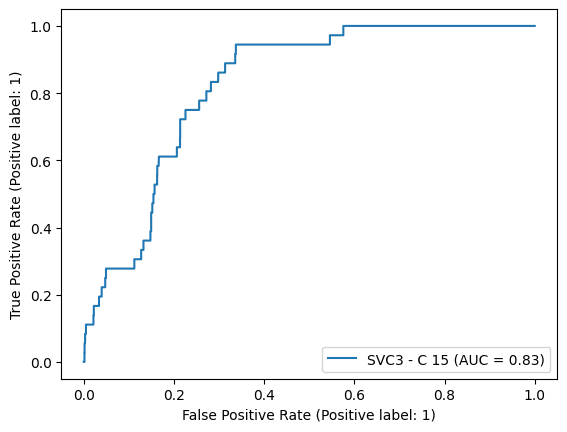

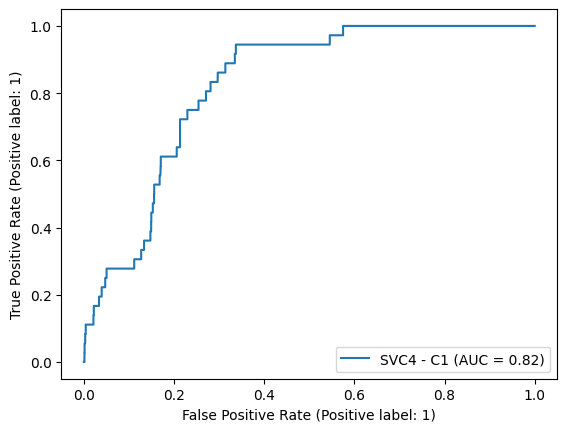

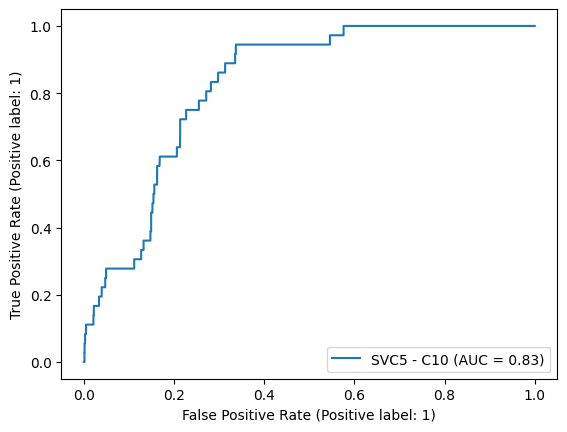

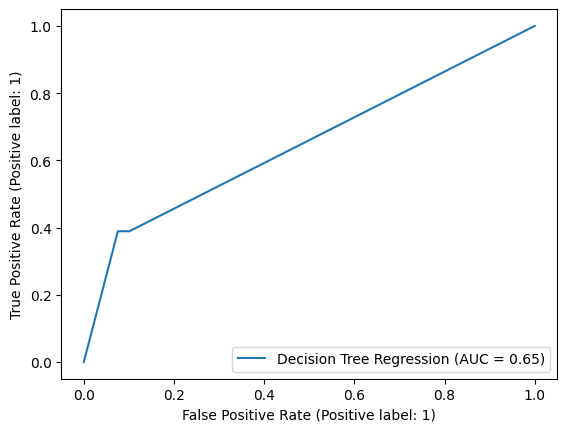

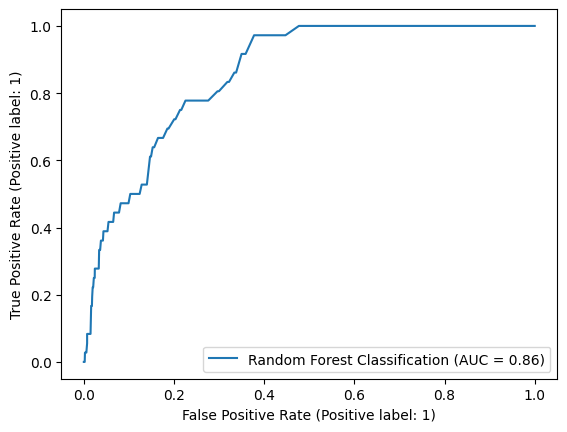

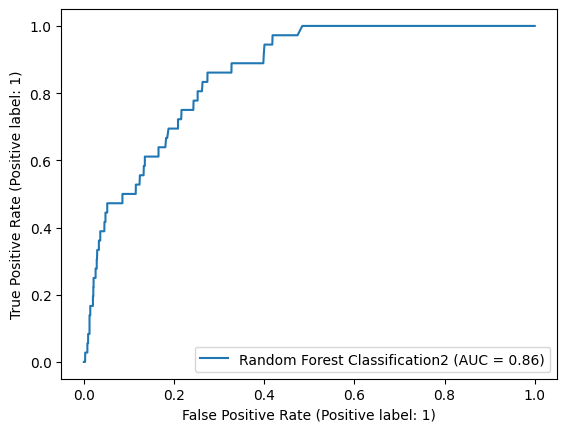

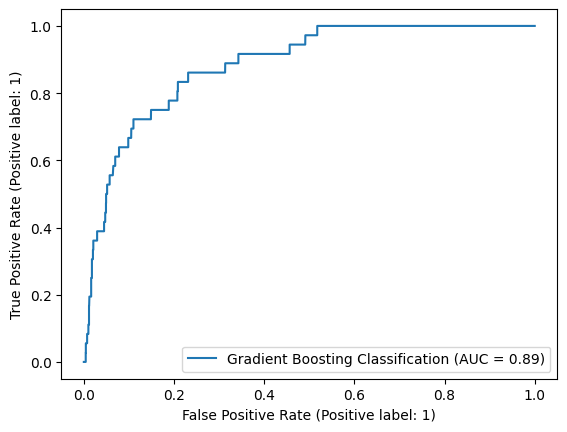

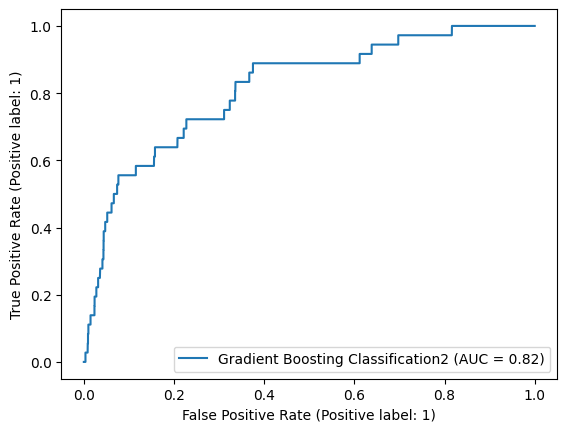

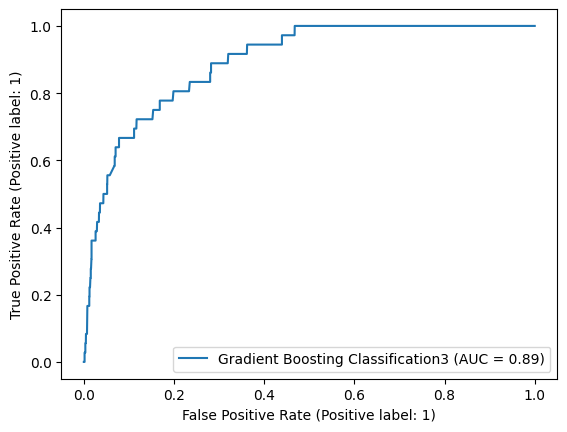

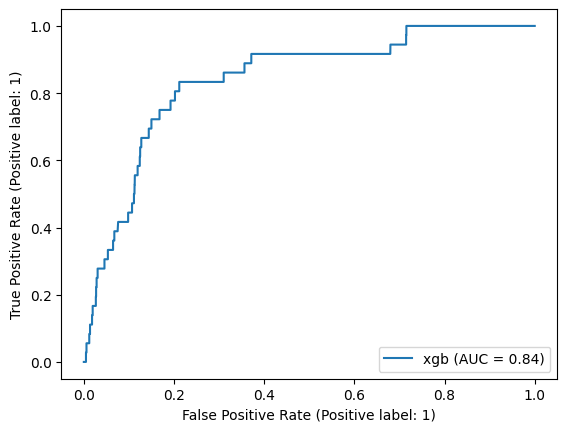

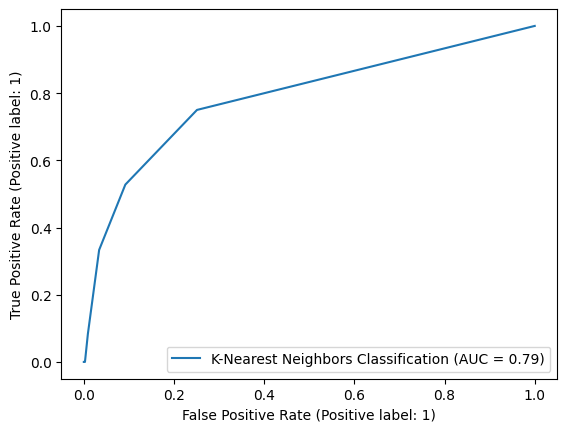

In [127]:
new_model_lists = []
for model in models:
    
    name = model[0]
    print(model[0])
    model = model[1]
    # pipe = Pipeline([('scaler', StandardScaler()), (name, model)])
    model.fit(X_train, y_train)
    # model.fit(x_smote, y_smote)
    # grids =  GridSearchCV(pipe, param_grid={}, scoring='f1', cv=3)
    # grids.fit(X, y)

    test_pred = model.predict(X_val_test)
    new_model_lists.append((name, model))
    # print('train result', result['test_score'])
    # grids.best_score_
    # print('mean_score:', -np.mean(result['test_score']))
    # y_preds = grids.best_estimator_.predict(X_test)
    print('auc', roc_auc_score(y_val_test, test_pred))
    # RocCurveDisplay.from_predictions(y_val_test, test_pred, name=name)
    # RocCurveDisplay.from_estimator(grids.best_estimator_, X_val_test, y_val_test, name=name)
    RocCurveDisplay.from_estimator(model, X_val_test, y_val_test, name=name)
    print(classification_report(y_val_test, test_pred))
    print('f1', f1_score(y_val_test, test_pred))
    
   

In [21]:
gb_ft_imp = new_model_lists[2][1].named_steps['model'].feature_importances_

In [22]:
df_copy = df.copy().drop(columns = ['will_break'])

In [23]:
# sortedgb = sorted(list(zip(list(df_copy.columns), new_model_lists[11][1].feature_importances_)), key = lambda x: x[1], reverse = True)
sortedgb = sorted(list(zip(list(df_copy.columns), gb_ft_imp)), key = lambda x: x[1], reverse = True)

In [24]:
features = [x[0] for x in sortedgb]
importances = [x[1] for x in sortedgb]

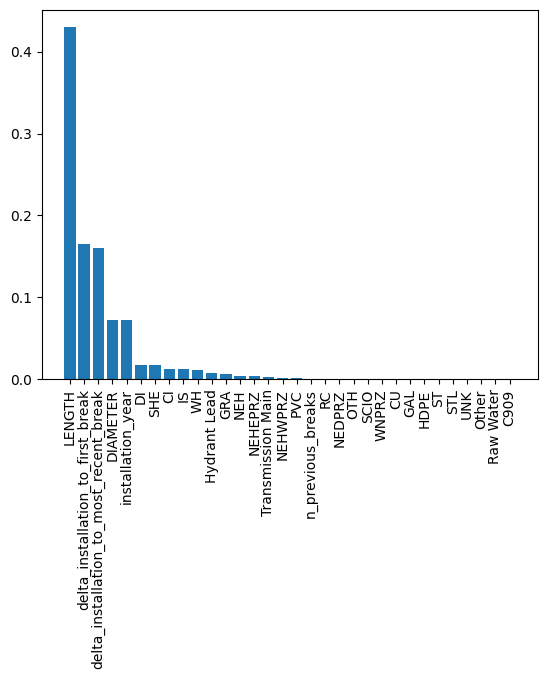

In [26]:
plt.bar(features, importances)
plt.xticks(rotation=90)
plt.show()

In [27]:
all_data_x = pd.concat([X_val_2023, X_test_2023], axis = 0)
all_data_y = pd.concat([y_val_2023, y_test_2023], axis = 0)

In [28]:
np.where(y_test_2023 == 1)

(array([2133, 2136, 2137, 2143, 2145, 2157]),)

In [29]:
all_data_x.fillna(0, inplace = True)

In [30]:
best_rf = new_model_lists[2][1]
best_svc = new_model_lists[1][1]

In [31]:
all_data_x.columns

Index(['LENGTH', 'DIAMETER', 'installation_year', 'n_previous_breaks',
       'delta_installation_to_first_break',
       'delta_installation_to_most_recent_break', 'GRA', 'NEH', 'NEHEPRZ',
       'NEHWPRZ', 'SCIO', 'SHE', 'WH', 'WNPRZ', 'IS', 'CI', 'CU', 'DI', 'HDPE',
       'PVC', 'RC', 'Hydrant Lead', 'Other', 'Transmission Main', 'C909',
       'GAL', 'UNK', 'NEDPRZ', 'OTH', 'ST', 'STL', 'Raw Water'],
      dtype='object')

In [32]:
preds = best_rf.predict(all_data_x)
print(classification_report(all_data_y, preds))
print(np.where(preds == 1))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3585
           1       0.07      0.46      0.12        13

    accuracy                           0.98      3598
   macro avg       0.53      0.72      0.55      3598
weighted avg       0.99      0.98      0.98      3598

(array([ 913,  970,  988, 1017, 1029, 1032, 1039, 1110, 1146, 1149, 1150,
       1151, 1160, 1161, 1165, 1167, 1174, 1182, 1183, 1189, 1194, 1195,
       1383, 1394, 1406, 1407, 1409, 1410, 1411, 1416, 1417, 1418, 1421,
       1422, 1425, 1426, 1427, 2852, 2863, 2902, 2921, 2925, 2952, 2976,
       2977, 2997, 3004, 3012, 3057, 3125, 3127, 3132, 3138, 3151, 3155,
       3199, 3208, 3211, 3222, 3229, 3235, 3242, 3246, 3247, 3254, 3260,
       3267, 3273, 3280, 3282, 3284, 3285, 3520, 3533, 3563, 3565, 3566,
       3570, 3574, 3576, 3582, 3586, 3587, 3589, 3592, 3596]),)


In [33]:

preds_svc = best_svc.predict_proba(all_data_x)

print(classification_report(all_data_y, preds))
print(np.where(preds_svc == 1))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3585
           1       0.07      0.46      0.12        13

    accuracy                           0.98      3598
   macro avg       0.53      0.72      0.55      3598
weighted avg       0.99      0.98      0.98      3598

(array([], dtype=int64), array([], dtype=int64))


In [313]:
all_data_y.index

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204],
      dtype='int64', length=3598)

In [314]:
zip_preds_rf = list(zip(preds, all_data_y, all_data_y.index))

In [ ]:
zip_preds_rf = list(zip(preds, all_data_y, all_data_y.index))
sorted(sorted(zip_preds_rf, key = lambda x: x[0], reverse = True), key = lambda x: x[1], reverse = True)

In [315]:
sorted(sorted(zip_preds_rf, key = lambda x: x[0], reverse = True), key = lambda x: x[1], reverse = True)

[(1, 1, 1456),
 (1, 1, 1457),
 (1, 1, 1458),
 (1, 1, 2183),
 (1, 1, 2189),
 (1, 1, 2203),
 (0, 1, 1418),
 (0, 1, 1421),
 (0, 1, 1445),
 (0, 1, 1446),
 (0, 1, 2179),
 (0, 1, 2182),
 (0, 1, 2191),
 (1, 0, 930),
 (1, 0, 990),
 (1, 0, 1008),
 (1, 0, 1038),
 (1, 0, 1050),
 (1, 0, 1054),
 (1, 0, 1061),
 (1, 0, 1136),
 (1, 0, 1172),
 (1, 0, 1175),
 (1, 0, 1176),
 (1, 0, 1177),
 (1, 0, 1186),
 (1, 0, 1187),
 (1, 0, 1191),
 (1, 0, 1193),
 (1, 0, 1201),
 (1, 0, 1211),
 (1, 0, 1212),
 (1, 0, 1218),
 (1, 0, 1223),
 (1, 0, 1224),
 (1, 0, 1414),
 (1, 0, 1425),
 (1, 0, 1437),
 (1, 0, 1438),
 (1, 0, 1440),
 (1, 0, 1441),
 (1, 0, 1442),
 (1, 0, 1447),
 (1, 0, 1448),
 (1, 0, 1449),
 (1, 0, 1452),
 (1, 0, 1453),
 (1, 0, 1447),
 (1, 0, 1458),
 (1, 0, 1500),
 (1, 0, 1520),
 (1, 0, 1524),
 (1, 0, 1551),
 (1, 0, 1575),
 (1, 0, 1576),
 (1, 0, 1596),
 (1, 0, 1603),
 (1, 0, 1611),
 (1, 0, 1657),
 (1, 0, 1727),
 (1, 0, 1729),
 (1, 0, 1734),
 (1, 0, 1740),
 (1, 0, 1753),
 (1, 0, 1757),
 (1, 0, 1801),
 (1, 0, 1810

In [316]:
zipPreds_svc = list(zip(preds_svc, all_data_y, all_data_y.index))

In [317]:
sorted(sorted(zipPreds_svc, key = lambda x: x[0][1], reverse = True), key = lambda x: x[1], reverse = True)

[(array([0.58223034, 0.41776966]), 1, 2179),
 (array([0.64026605, 0.35973395]), 1, 2203),
 (array([0.66010969, 0.33989031]), 1, 2189),
 (array([0.66056109, 0.33943891]), 1, 1456),
 (array([0.66100774, 0.33899226]), 1, 1458),
 (array([0.67193395, 0.32806605]), 1, 2191),
 (array([0.67832017, 0.32167983]), 1, 1457),
 (array([0.71684858, 0.28315142]), 1, 1445),
 (array([0.71869048, 0.28130952]), 1, 1418),
 (array([0.72303079, 0.27696921]), 1, 2182),
 (array([0.72487891, 0.27512109]), 1, 2183),
 (array([0.72739446, 0.27260554]), 1, 1421),
 (array([0.7517452, 0.2482548]), 1, 1446),
 (array([0.35276113, 0.64723887]), 0, 378),
 (array([0.44424502, 0.55575498]), 0, 1061),
 (array([0.4587636, 0.5412364]), 0, 1394),
 (array([0.46243832, 0.53756168]), 0, 1384),
 (array([0.466777, 0.533223]), 0, 2137),
 (array([0.49127918, 0.50872082]), 0, 2127),
 (array([0.51531837, 0.48468163]), 0, 742),
 (array([0.52503481, 0.47496519]), 0, 2090),
 (array([0.52571112, 0.47428888]), 0, 2126),
 (array([0.53745492,

In [255]:
all_data_x.iloc[np.where(preds == 1)[0]]

,LENGTH,DIAMETER,C909,GAL,UNK,NEDPRZ,OTH,ST,STL,Raw Water,...,IS,CI,CU,DI,HDPE,PVC,RC,Hydrant Lead,Other,Transmission Main
930,564.0,8.0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
990,422.0,8.0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
1008,444.0,4.0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1038,544.0,8.0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1050,647.0,6.0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193,541.0,6.0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
2194,395.0,6.0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
2196,510.0,4.0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
2199,308.0,4.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


### Preds

class 0: (18212, 34)
class 1: (669, 34)
total class of 1 and0: will_break
0    6021
1     669
Name: count, dtype: int64


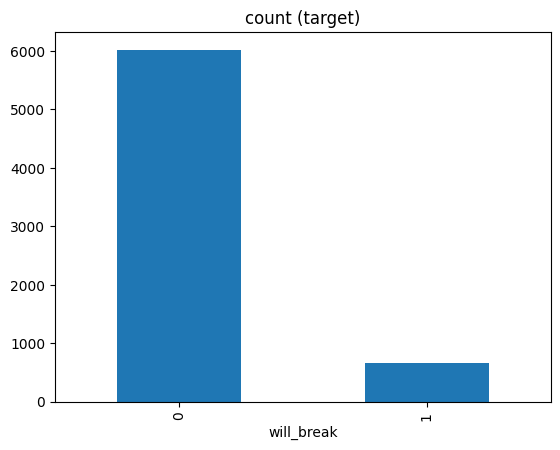

In [54]:
# class count
class_count_0, class_count_1 = preds_df['will_break'].value_counts()

# Separate class
class_0 = preds_df[preds_df['will_break'] == 0]
class_1 = preds_df[preds_df['will_break'] == 1]# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)
class_0_under = class_0.sample(class_count_1*9, random_state=14)

test_under_preds = pd.concat([class_0_under, class_1], axis=0)
print("total class of 1 and0:",test_under_preds['will_break'].value_counts()) # plot the count after under-sampling
test_under_preds['will_break'].value_counts().plot(kind='bar', title='count (target)')

y_train_preds = test_under_preds['will_break']
X_train_preds = test_under_preds.drop(columns = ['will_break'])

X_test_preds = pred_test_df.drop(columns = ['will_break'])
y_test_preds = pred_test_df['will_break']

In [55]:
params = {'max_depth': 5, 'max_features': 17, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0, 'n_estimators': 90, 'random_state': 13}

In [84]:
for col in X_train_preds.columns:
    if col not in X_train.columns:
        print(col)

SEH


In [85]:
X_train_preds.drop(columns= ['SEH'], inplace = True)
X_test_preds.drop(columns= ['SEH'], inplace = True)

In [58]:
X_test_preds.columns

Index(['LENGTH', 'DIAMETER', 'installation_year', 'n_previous_breaks',
       'delta_installation_to_first_break',
       'delta_installation_to_most_recent_break', 'GRA', 'NEDPRZ', 'NEH',
       'NEHEPRZ', 'NEHWPRZ', 'OTH', 'SCIO', 'SHE', 'WH', 'WNPRZ', 'IS', 'C909',
       'CI', 'CU', 'DI', 'GAL', 'HDPE', 'PVC', 'RC', 'ST', 'STL', 'UNK',
       'Hydrant Lead', 'Other', 'Raw Water', 'Transmission Main'],
      dtype='object')

In [73]:
X_train_preds

,LENGTH,DIAMETER,installation_year,n_previous_breaks,delta_installation_to_first_break,delta_installation_to_most_recent_break,GRA,NEDPRZ,NEH,NEHEPRZ,NEHWPRZ,OTH,SCIO,SHE,WH,WNPRZ,IS,CI,CU,DI,GAL,HDPE,PVC,RC,ST,STL,UNK,Hydrant Lead,Other,Raw Water,Transmission Main,C909
21387,1.0,6.0,1940,0,23742,23742,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21234,159.0,6.0,1950,0,20089,20089,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23530,3.0,6.0,1910,0,34699,34699,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17674,252.0,20.0,1963,0,15030,15030,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
8260,0.0,8.0,1997,0,2741,2741,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27473,45.0,6.0,1940,0,23742,23742,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27474,71.0,6.0,1950,0,20089,20089,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27476,43.0,6.0,1962,0,15617,15617,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27477,0.0,6.0,1960,0,16437,16437,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [86]:
y_train_preds = preds_df['will_break']
X_train_preds = preds_df.drop(columns = ['will_break'])

X_test_preds = pred_test_df.drop(columns = ['will_break'])
y_test_preds = pred_test_df['will_break']
X_train_preds.shape

(20455, 33)

In [75]:
# make X_train_preds and X_train have same columns in the same order
X_train_preds2 = X_train_preds[X_train.columns]
X_test_preds2 = X_test_preds[X_train.columns]
X_val_test2 = X_val_test[X_train.columns]

In [76]:
X_train_preds2

,LENGTH,DIAMETER,installation_year,n_previous_breaks,delta_installation_to_first_break,delta_installation_to_most_recent_break,GRA,NEDPRZ,NEH,NEHEPRZ,NEHWPRZ,OTH,SCIO,SHE,WH,WNPRZ,IS,CI,CU,DI,GAL,HDPE,PVC,RC,ST,STL,UNK,Hydrant Lead,Other,Raw Water,Transmission Main,C909
6013,0.0,12.0,2004,0,10,10,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6014,0.0,8.0,2004,0,10,10,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
6015,0.0,12.0,2004,0,10,10,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6016,0.0,12.0,2004,0,10,10,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6017,0.0,12.0,2004,0,10,10,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27473,45.0,6.0,1940,0,23742,23742,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27474,71.0,6.0,1950,0,20089,20089,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27476,43.0,6.0,1962,0,15617,15617,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27477,0.0,6.0,1960,0,16437,16437,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [77]:
rf_preds = RandomForestClassifier(**params)
rf_preds.fit(X_train_preds2, y_train_preds)
preds = rf_preds.predict_proba(X_test_preds2)
preds2 = rf_preds.predict(X_val_test2)
print(classification_report(y_val_test, preds2))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3562
           1       0.00      0.00      0.00        36

    accuracy                           0.99      3598
   macro avg       0.49      0.50      0.50      3598
weighted avg       0.98      0.99      0.99      3598



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
preds

array([[0.99652072, 0.00347928],
       [0.99652072, 0.00347928],
       [0.99281702, 0.00718298],
       ...,
       [0.92360034, 0.07639966],
       [0.95000913, 0.04999087],
       [0.79387749, 0.20612251]])

In [79]:
zip_preds_rf_final = list(zip(preds, y_test_preds, y_test_preds.index))
sorty_list = sorted(sorted(zip_preds_rf_final, key = lambda x: x[0][1], reverse = True), key = lambda x: x[1], reverse = True)

In [80]:
sorty_list[:10]

[(array([0.54561544, 0.45438456]), 0, 27072),
 (array([0.54561544, 0.45438456]), 0, 27100),
 (array([0.56574112, 0.43425888]), 0, 27277),
 (array([0.56574112, 0.43425888]), 0, 27278),
 (array([0.56832775, 0.43167225]), 0, 27073),
 (array([0.56832775, 0.43167225]), 0, 27096),
 (array([0.56832775, 0.43167225]), 0, 27097),
 (array([0.56866867, 0.43133133]), 0, 17444),
 (array([0.57318913, 0.42681087]), 0, 27271),
 (array([0.573861, 0.426139]), 0, 26956)]

In [64]:
idx_l = [x[2] for x in sorty_list[:15]]
idx_l

[27277,
 27278,
 17444,
 27271,
 27373,
 27072,
 27100,
 27144,
 26956,
 27073,
 27096,
 27097,
 27365,
 26893,
 27205]

In [207]:
idx_l = [x[2] for x in sorty_list[:15]]
idx_l

[17444,
 17912,
 17396,
 18195,
 18201,
 18202,
 18209,
 18466,
 18520,
 17911,
 18611,
 18686,
 18206,
 18464,
 18613]

In [67]:
idx_l = [x[2] for x in sorty_list[:15]]
idx_l
import pandas as pd
pd.set_option('display.max_columns', None)
X_test_preds2.loc[X_test_preds2.index.isin(idx_l)][:15]

,LENGTH,DIAMETER,installation_year,n_previous_breaks,delta_installation_to_first_break,delta_installation_to_most_recent_break,GRA,NEDPRZ,NEH,NEHEPRZ,NEHWPRZ,OTH,SCIO,SHE,WH,WNPRZ,IS,CI,CU,DI,GAL,HDPE,PVC,RC,ST,STL,UNK,Hydrant Lead,Other,Raw Water,Transmission Main,C909
17444,756.0,6.0,1964,0,21648,21648,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26893,458.0,6.0,1963,2,19116,19116,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26956,590.0,6.0,1961,2,21179,21179,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27072,967.0,6.0,1960,1,19849,19849,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27073,692.0,6.0,1960,1,20116,20116,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27096,686.0,6.0,1960,1,20093,20093,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27097,613.0,6.0,1960,1,20072,20072,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27100,905.0,6.0,1960,1,20247,20247,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27144,553.0,6.0,1963,1,18094,18094,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27205,795.0,6.0,1962,1,21489,21489,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [199]:
X_test_preds2

,LENGTH,DIAMETER,installation_year,n_previous_breaks,delta_installation_to_first_break,delta_installation_to_most_recent_break,GRA,NEDPRZ,NEH,NEHEPRZ,...,PVC,RC,ST,STL,UNK,Hydrant Lead,Other,Raw Water,Transmission Main,C909
0,7.0,6.0,2023,0,81,81,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,9.0,6.0,2023,0,88,88,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,20.0,6.0,2023,0,139,139,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,9.0,6.0,2023,0,140,140,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,13.0,6.0,2023,0,167,167,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27474,71.0,6.0,1950,1,23042,23042,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27475,19.0,10.0,2009,1,4077,4077,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27476,43.0,6.0,1962,1,20709,20709,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
27477,0.0,6.0,1960,1,22604,22604,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [208]:
import pandas as pd
pd.set_option('display.max_columns', None)
X_test_preds2.loc[X_test_preds2.index.isin(idx_l)][:15]



,LENGTH,DIAMETER,installation_year,n_previous_breaks,delta_installation_to_first_break,delta_installation_to_most_recent_break,GRA,NEDPRZ,NEH,NEHEPRZ,NEHWPRZ,OTH,SCIO,SHE,WH,WNPRZ,IS,CI,CU,DI,GAL,HDPE,PVC,RC,ST,STL,UNK,Hydrant Lead,Other,Raw Water,Transmission Main,C909
17396,410.0,6.0,1964,0,21602,21602,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17444,756.0,6.0,1964,0,21648,21648,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17911,396.0,6.0,1963,0,22164,22164,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17912,533.0,6.0,1963,0,22164,22164,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18195,672.0,6.0,1962,0,22567,22567,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18201,474.0,6.0,1962,0,22567,22567,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18202,628.0,6.0,1962,0,22567,22567,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18206,394.0,6.0,1962,0,22567,22567,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18209,421.0,6.0,1962,0,22567,22567,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18464,393.0,6.0,1961,0,22866,22866,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [200]:
X_test_preds2.loc[X_test_preds2.index.isin(idx_l)][:15].to_csv('top_15.csv')

In [201]:
predsX.loc[predsX.index.isin(idx_l)][:15].to_csv('top_152.csv')

In [192]:
X_test_preds2

,LENGTH,DIAMETER,installation_year,n_previous_breaks,delta_installation_to_first_break,delta_installation_to_most_recent_break,GRA,NEDPRZ,NEH,NEHEPRZ,...,PVC,RC,ST,STL,UNK,Hydrant Lead,Other,Raw Water,Transmission Main,C909
0,7.0,6.0,2023,0,81,81,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,9.0,6.0,2023,0,88,88,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,20.0,6.0,2023,0,139,139,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,9.0,6.0,2023,0,140,140,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,13.0,6.0,2023,0,167,167,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27474,71.0,6.0,1950,1,23042,23042,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27475,19.0,10.0,2009,1,4077,4077,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27476,43.0,6.0,1962,1,20709,20709,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
27477,0.0,6.0,1960,1,22604,22604,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [197]:
X_test_preds2.iloc[idx_l]

,LENGTH,DIAMETER,installation_year,n_previous_breaks,delta_installation_to_first_break,delta_installation_to_most_recent_break,GRA,NEDPRZ,NEH,NEHEPRZ,...,PVC,RC,ST,STL,UNK,Hydrant Lead,Other,Raw Water,Transmission Main,C909
17837,0.0,12.0,1963,0,22091,22091,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18308,0.0,8.0,1961,0,22704,22704,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17789,2.0,6.0,1963,0,22077,22077,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18591,132.0,6.0,1960,0,23121,23121,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18597,164.0,8.0,1960,0,23121,23121,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18598,0.0,6.0,1960,0,23132,23132,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18605,0.0,6.0,1960,0,23132,23132,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18873,26.0,4.0,1960,0,23376,23376,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18927,12.0,6.0,1960,0,23376,23376,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18307,12.0,6.0,1961,0,22703,22703,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [190]:
X_test_preds2.iloc[idx_l][:15].to_csv('top_15.csv', index = True)
predsX.iloc[idx_l][:15].to_csv('top_152.csv', index = True)

In [118]:
sorted(preds, key = lambda x: x[1], reverse = True)

[array([0.30160201, 0.69839799]),
 array([0.30803786, 0.69196214]),
 array([0.30969191, 0.69030809]),
 array([0.31257312, 0.68742688]),
 array([0.31257312, 0.68742688]),
 array([0.31257312, 0.68742688]),
 array([0.31257312, 0.68742688]),
 array([0.31804424, 0.68195576]),
 array([0.31804424, 0.68195576]),
 array([0.31991437, 0.68008563]),
 array([0.32430953, 0.67569047]),
 array([0.32430953, 0.67569047]),
 array([0.32444963, 0.67555037]),
 array([0.32992075, 0.67007925]),
 array([0.33618604, 0.66381396]),
 array([0.34050294, 0.65949706]),
 array([0.34243293, 0.65756707]),
 array([0.34364868, 0.65635132]),
 array([0.34609504, 0.65390496]),
 array([0.34626876, 0.65373124]),
 array([0.34688892, 0.65311108]),
 array([0.34747225, 0.65252775]),
 array([0.34817372, 0.65182628]),
 array([0.34964787, 0.65035213]),
 array([0.3501681, 0.6498319]),
 array([0.35064497, 0.64935503]),
 array([0.35164027, 0.64835973]),
 array([0.35173858, 0.64826142]),
 array([0.35318959, 0.64681041]),
 array([0.353189

In [108]:
np.where(preds2 == 1)[0].shape

(62,)

In [107]:
for idx in y_train_preds.index:
    if idx in X_val_test2.iloc[np.where(preds2 == 1)].index:
   
        print(idx)

1456
1824
1729
1524


In [114]:
len(y_test_preds)

24787

In [113]:
cot = 0
for idx in y_train_preds.index:
    if idx in y_test_preds.iloc[np.where(preds == 1)].index:
        cot += 1
        print(idx)
cot

18534
17520
20229
17657
21165
21091
18428
20802
18521
20701
21072
20439
17946
17612
21138
17875
16762
18624
20127
18200
19285
18802
20858
20957


24

In [112]:
np.where(preds == 1)[0].shape

(373,)

In [100]:
y_test_preds.iloc[np.where(preds == 1)].index

Index([1017, 1043, 1046, 1058, 1068, 1128, 1139, 1149, 1167, 1176, 1179, 1180,
       1181, 1190, 1191, 1192, 1195, 1198, 1356, 1361, 1449, 1457, 1460, 1461,
       1462, 2977, 2981, 3007, 3008, 3032, 3033, 3053, 3068, 3113, 3122, 3170,
       3174, 3181, 3183, 3188, 3194, 3200, 3207, 3211, 3255, 3260, 3264, 3267,
       3278, 3285, 3287, 3291, 3297, 3298, 3302, 3303, 3641, 3650, 3660, 3662,
       3671, 3674],
      dtype='int64')

<h2>Cross Validation</h2>

In [21]:
svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [22]:
svc.score(X_test, y_test)

0.9908883826879271

In [26]:
pred = svc.predict(X_val)

In [28]:
print(classification_report(pred, y_val))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       525
           1       0.00      0.00      0.00         0

    accuracy                           0.98       525
   macro avg       0.50      0.49      0.50       525
weighted avg       1.00      0.98      0.99       525



/Users/haleyjohnson/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haleyjohnson/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haleyjohnson/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
f1_score(pred, y_val)

0.0

In [33]:
auc(pred, y_val)

0.0